<h1 align="center"><font size="5">Applied Data Science Capstone Final - Nikhil M</font></h1>

## Introduction

Toronto and New York are the respective financial centers of their countries. In this post, I will examine how similar or dissimilar the two cities are in terms of their constituent neighborhoods. 


## Business Problem

I see this analysis from the perspective of someone working in the financial industry who is contemplating a move from one city to the other. Through this analysis, such a person would be able to move to a neighborhood that is most similar to the one he/she is currently living in.

## Data

The data for this analysis will be acquired through the following sources - 

* Wikipedia - For the collection of neighbourhoods in Toronto.
* NYU Website - Dataset containing the latitude and longitude information for neighbourhoods in NY.
* Coursera - Dataset containing the latitude and longitude information for neighbourhoods in Toronto.
* FourSquare API - For exploring the vicinity of a given latitude and longitude.

## Kicking off the process with library imports and initializations

In [1]:
import numpy as np
import pandas as pd

import json # library to handle JSON files

import requests # library to handle requests
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
from lxml import etree

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  24.25 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  36.98 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  56.71 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.87 MB/s
vincent-0.4.4- 100% |###################

## Extracting and preparing the neighbourhood information for Toronto

In [35]:
#Extract neighborhoods in Toronto
base_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
tables = pd.read_html(base_url) 

#Extract table with list of neighborhoods
df_neighborhoods = tables[0]

#Assign column headers & drop unnecessary columns
df_neighborhoods.columns = df_neighborhoods.iloc[0]
df_neighborhoods = df_neighborhoods.reindex(df_neighborhoods.index.drop(0))
df_neighborhoods = df_neighborhoods[df_neighborhoods["Borough"] != "Not assigned"]
df_neighborhoods = df_neighborhoods.reset_index(drop=True)

#df_neighborhoods.head()

group_by_neighborhoods = df_neighborhoods.groupby(['Postcode'])

column_headers = ['Postcode', 'Borough', 'Neighbourhood']
final_neighborhood_data = pd.DataFrame(columns=column_headers)
final_neighborhood_data.columns = column_headers

for name, group in group_by_neighborhoods:
    #Get individual neighborhood names
    combinedNames = ""
    for colName in group["Neighbourhood"]:
        combinedNames = colName + ',' + combinedNames
    combinedNames = combinedNames[:-1]    

    #Create a row and add it to the new dataframe as required in the question
    finalDataRow = pd.Series([name, group["Borough"].values[0], combinedNames], index=column_headers)    
    final_neighborhood_data = final_neighborhood_data.append(finalDataRow, ignore_index=True)
    
#CSV for lats and longs for Toronto
coordinates_url = "https://cocl.us/Geospatial_data"
coordinates_data = pd.read_csv(coordinates_url) 
coordinates_data.columns = ["Postcode", "Latitude", "Longitude"]

toronto_neighborhoods = pd.merge(final_neighborhood_data,
                                   coordinates_data,
                                   on="Postcode")

toronto_neighborhoods = toronto_neighborhoods.drop(['Postcode'], axis = 1)

toronto_neighborhoods.shape

(103, 4)

## Extracting and preparing the neighbourhood information for New York

In [36]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
    
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

ny_neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)

for data in ny_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
ny_neighborhoods.shape

(306, 4)

## Consolidate information from both cities into a single dataframe

In [4]:
df_merged = pd.concat([ny_neighborhoods, toronto_neighborhoods])

df_merged.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Use FourSquare API to explore neighbourhoods in both cities

In [5]:
#Initialize constants for FourSquare
CLIENT_ID = 'blah' # your Foursquare ID
CLIENT_SECRET = 'meh' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

merged_neighborhood_venues = getNearbyVenues(names=df_merged['Neighbourhood'],
                                   latitudes=df_merged['Latitude'],
                                   longitudes=df_merged['Longitude'])

merged_neighborhood_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Dunkin Donuts,40.890631,-73.849027,Donut Shop
4,Wakefield,40.894705,-73.847201,SUBWAY,40.890656,-73.849192,Sandwich Place


## Pre process merged neighbourhood data before clustering

In [7]:
# one hot encoding
merged_onehot = pd.get_dummies(merged_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
merged_onehot['Neighbourhood'] = merged_neighborhood_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [merged_onehot.columns[-1]] + list(merged_onehot.columns[:-1])
merged_onehot = merged_onehot[fixed_columns]

all_grouped = merged_onehot.groupby('Neighbourhood').mean().reset_index()
all_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [9]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = all_grouped['Neighbourhood']

for ind in np.arange(all_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Sandwich Place,Lounge,Breakfast Spot,Skating Rink,Yoga Studio,Falafel Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service
1,Allerton,Pizza Place,Supermarket,Deli / Bodega,Chinese Restaurant,Spa,Bus Station,Department Store,Martial Arts Dojo,Discount Store,Fast Food Restaurant
2,Annadale,Pizza Place,Sports Bar,Liquor Store,Sushi Restaurant,Train Station,Diner,Restaurant,Factory,Electronics Store,Empanada Restaurant
3,Arden Heights,Coffee Shop,Business Service,Pizza Place,Pharmacy,Farm,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service
4,Arlington,Food Service,Coffee Shop,Intersection,Bus Stop,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor


## Creating clusters out of processed data

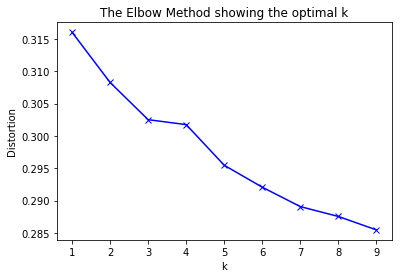

In [23]:
all_grouped_clustering = all_grouped.drop('Neighbourhood', 1)

# create new plot and data
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(all_grouped_clustering)
    kmeanModel.fit(all_grouped_clustering)
    distortions.append(sum(np.min(cdist(all_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / all_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [25]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels', axis = 1)

# set number of clusters
kclusters = 3

all_grouped_clustering = all_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#toronto_merged = df_neighborhoods
all_merged = df_merged

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
all_merged = all_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

#Clean up cluster label values to display on map
all_merged_final = all_merged.drop(all_merged[all_merged['Cluster Labels'].isna()].index)
all_merged_final['Cluster Labels'] = all_merged_final['Cluster Labels'].astype(int)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Create a map to visualize the clusters

In [28]:
all_merged_final.head()

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1,Ice Cream Shop,Dessert Shop,Food Truck,Donut Shop,Laundromat,Sandwich Place,Pizza Place,Pharmacy,Egyptian Restaurant,Electronics Store
1,Bronx,Co-op City,40.874294,-73.829939,1,Bus Station,Baseball Field,Ice Cream Shop,Restaurant,Fried Chicken Joint,Mattress Store,Basketball Court,Gift Shop,Liquor Store,Park
2,Bronx,Eastchester,40.887556,-73.827806,1,Bus Station,Caribbean Restaurant,Deli / Bodega,Metro Station,Diner,Juice Bar,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Pizza Place
3,Bronx,Fieldston,40.895437,-73.905643,2,Plaza,Playground,River,Yoga Studio,Farm,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,2,Food Truck,Plaza,Playground,Bank,Park,Home Service,Gym,Factory,Egyptian Restaurant,Electronics Store


In [34]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

geolocator = Nominatim(user_agent="toronto_explorer")
toronto_location = geolocator.geocode("Toronto")
kclusters = 3

# create map
map_clusters = folium.Map(location=[toronto_location.latitude, toronto_location.longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_merged_final['Latitude'], 
                                  all_merged_final['Longitude'], 
                                  all_merged_final['Neighbourhood'], 
                                  all_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters